In [98]:
import sys
sys.version

'3.12.5 | packaged by conda-forge | (main, Aug  8 2024, 18:32:50) [Clang 16.0.6 ]'

In [99]:
import gensim

In [103]:
gensim

<module 'gensim' (namespace) from ['/Users/gawron/opt/anaconda3/envs/p312/lib/python3.12/site-packages/gensim']>

## Modeling word meaning 

The old structuralist idea that word meanings can be modeled by word co-occurrence patterns, that
words with similar meanings should have similar co-occurrence patterns:

> You shall know a word by the company it keeps. -- Firth

Our text  calls this idea the **Distributional Hypothesis**:

>The distributional hypothesis $\dots$ proposes that some aspects of meaning can be learned solely from the texts we encounter over our lives, based on the complex association of words with the words they co-occur with (and with the words that those words occur with) --  Chap 5, 7

So to build a model of word meaning, let's build a model of that sort. 

But what kind of object (data structure) shall we use for a word meaning?

Given the tight connection between word meaning and word distribution we're assuming,
a reasonable place to look is at **language models**, which are probabilistic models
of word distribution.  Bengio et al. discusses the idea of building **language models** based  on
n-dimensional vectors, proposing a shift from **n-gram** models in which
a 10-gram model for a vocab of 100,000 words has

$$
100,000^{10} - 1 = 10^{50} - 1
$$

parameters to, say, 100-dimensional vectors (or **embeddings**) for the same vocabulary, with
$$
100,000 * 100 = 10^{7}
$$

parameters.  The idea is that the vectors themselves will model the probability distribution  for
the 10-word window around each word.  Aside from the smaller easier-to-train parameter space,
Bengio et al. cites this reason to think word embeddings could provide an improvement in
language modeling:

> Model generalizability:  Suppose that we try to predict the occurrence of some word $c$ never seen before in the context of our target word $w$.  In a classic n-gram model all such words will receive the same probability (with a few qualifications here for certain smoothing strategies). In a vector-based model, words with distributions similar to words we **have** seen in the context can receive higher probabilities.  That is, for any given word $w$ the context coverage of our model expands from the words we have seen in context with $w$  to words similar to the words we have seen in context with $w$.  Their example:   Seeing *The cat is walking in the bedroom* should increase the probability of 

> The dog is walking in the bedroom.

> A cat is walking in the bedroom.

> The cat is running in the bedroom.

> The dog is running in the bedroom.

and so on.  Bengio et al. proposed a neural network model which achieved state-of-the-art perplexity scores
(interestingly, because the NN models make very different kinds of errors from the best trigram model --an interpolated trigram -- the best scores were achieved by mixing the two models).  
Collobert et al (2011) used a different NN architecture and achieved state-of-the-art performance on 
language modeling and a number of NLP tagging tasks, including part of speech tagging, semantic tagging, and parsing. The two systems shared the property of using multi-dimensional models of 
words coupled with a fairly simple Neural Net architecture.

The 3-D model of affect.  A preliminary **word vector** model.  Also **Latent Semantic Indexing** in
the context of information-retrieval (Deerwester etal 1988, which introduces the term **embedding**).
This uses truncated SVD representations of a matrix of co-occurrence counts of words.

So now we know: We can represent meaning with n-dimensional continuous vectors and this may
offer significant advantages in both language-modeling and meaning representation.

In this notebook we we explore the **Word2Vec** model of Mikolov et al. (2013), an approach that computes embeddings for words without coupling them to a neural net architecture.  Word vectors are simply
trained to do language modeling as well as possible. This simplifies the learning
task and yet produces vectors that poerform well on a number of benchmarks.

The goal is to train the model so that words with similar co-occurrence
patterns have similar vectors. The basic intuition of how that works is: We get a large 
sample (or, **corpus**) of naturally occurring language (usually written, usually on the internet)
and apply some measure of how similar a word's vector is to the word vectors of its context
words.  We define improving our model as increasing those similarity scores.


## Skip gram model (Mikolov 2013)

First we need a way of measuring similarity of vectors.  Let's use a very simple idea:

$$
\begin{array}{lcl}
\text{Similarity}(w,\,c) & = & \mathbf{c}\cdot\mathbf{w}\\
\end{array}
$$

To make our model probablistic (a la Bengio et al. 2003)
we  map similarity scores to probabilities.  The more similar a word is
to its context words the more probable the occurrence of those context words is.



**Logistic** or **sigmoid** function beloved of logistic regression models:
$$
\sigma:\; R \rightarrow ( 0,\, 1 )
$$

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

The probability that word $c$ is a real context word for target word $w$ is:
$$
\text{P}(+\mid\, \mathbf{w,c}) = \sigma(\mathbf{c}\cdot\mathbf{w}) =  \frac{1}{1 + e^{-\mathbf{c\cdot w}}}
$$

Note that $\text{P}(+\mid\mathbf{\cdot})$ is a symmetric function. The probability of $w$ being a context word
for $c$ is the same as the probability of $c$ being a context word
for $w$.  This is consistent with our setup.  Since the left and right context windows are the
same, for any given utterance, $w$ is a context word for $c$ if and only if $c$ is a context word for $w$.  

Nevertheless, in the implementtion of the **Skip Gram with Negative Sampling** (SGNS) model, we train 
separate target word and context vectors for each word.

In [85]:
import numpy as np

def sigmoid(x):
    return (1 + np.exp(-x))**(-1)

c = np.array([.2,.3, -.6])
# A vector whose dot product with c is 0 is orthogonal to c.
c_orth = np.array([5,1/.3, 2/(.6)])
#sigmoid(0) =.5
sigmoid(c.dot(c_orth))

np.float64(0.5)

Orthogonal vectors:

In [18]:
c.dot(c_orth)

np.float64(-1.480297366166875e-17)

Completely orthogonal vectors means the probability of being a target context word pair and not being a target context word pair is the same.

In [19]:
sigmoid(c.dot(c_orth))

np.float64(0.5)

In [25]:
sigmoid(10)

np.float64(0.9999546021312976)

In [26]:
sigmoid(-10)

np.float64(4.5397868702434395e-05)

As desired, the larger $\mathbf w\cdot c$ is, the higher the probability of target-word/context-word relation;
that is, the the more similar the target word and context word vectors are, the greater the probability of co-occurrence.

In [73]:
sigmoid(1.5)

np.float64(0.8175744761936437)

## Sampling model 

We can think of  the SGNS model as a probability-based classifier: given a target word $w$ we classify candidates
$c$ as to whether they can or cannot be context words for $w$, depending
on their probability of being a context word for $w$. To train a classifier we need
to consider negative examples as well as positive ones, and the model
we've chosen has a particularly elegant answer for negative examples:

The probability that word $c$ is **not** a real context word for target word $w$ is:

$$
\begin{array}[t]{lcl}
\text{P}(-\mid\, w,c) &=& 1 - \text{P}(+\mid\, \mathbf{w,c}) \\
& = &1 - \sigma(\mathbf {c\cdot w }) \\
& = &\sigma(-\mathbf{c}\cdot\mathbf{w}) \\
\end{array}
$$

This follows because of a key property of the sigmoid function 
(which helps makes it attractive for probabilistic models  like
logistic regression):  $1 - \sigma(x) = \sigma(-x)$
$$
1 - \sigma(x)  = 1 - \frac{1}{1 + e^{\,-x}}
=  \frac{1 + e^{-x} -1}{1 + e^{\,x}} = 
\frac{e^{x}(e^{-x})}{e^{\,x}(1 + e^{-x})} =
\frac{1}{1 + e^{\, \mathbf x}} =
\sigma(-x) 
$$

Summarizing: we want a vector model of dimensionality $n$ for
word co-occurrences.  We model co-coccurence with vector similarity
because we have a particularly simple model of vector similarity,
dot product. Our similarity "scores" range from $-\infty$ to $\infty$,
so to get a probability model, we use $\sigma$ to map from
$\mathbf c\cdot w $ to the open interval from  0 to 1.
$\sigma$ has the advantage of a mathematically simple relation
$\sigma(x)$ = $1- \sigma(-x)$, which will give oue learning
algorithm parfticularly simple way of training with negative examples.

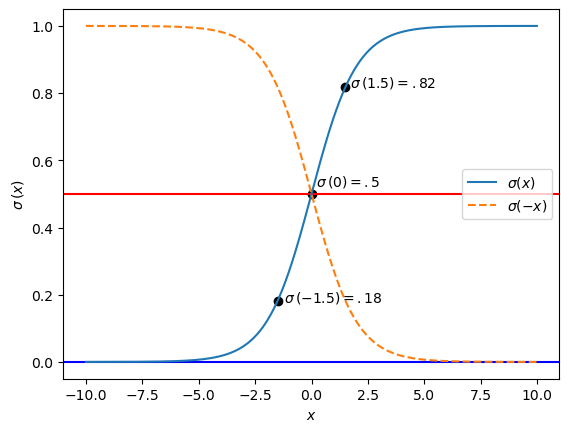

In [97]:
from matplotlib import pyplot as plt

(fig,ax) = plt.subplots(1,1)
x = np.arange(-10,10,.01)
y = sigmoid(x)
y_prime = sigmoid(-x)
ax.axhline(.5,c="r")
ax.annotate(r"$\sigma\,(0) = .5$",(.19,.525),)
ax.annotate(r"$\sigma\,(1.5)=.82$",(1.7,.82),)
ax.annotate(r"$\sigma\,(-1.5)=.18$",(-1.2,.18),)
ax.scatter([-1.5,0,1.5],[.1824,.5,.8175],c="k")
ax.axhline(c="b")
ax.plot(x,y,label=r"$\sigma(x)$")
ax.plot(x,y_prime,linestyle="--",label=r"$\sigma(-x)$")
ax.set_xlabel(r"$x$")
_ = ax.set_ylabel(r"$\sigma\,(x)$")
ax.legend()

To find negative examples: randomly choose $k$ noise words for each target word token.  First guess: We sample
"randomly" in accordance with the known unigram distributions of the vocabulary V.  For each word $w$,
we estimate $\text{P}(w)$ with its relative frequency in the corpus:

$$
\text{P}(w)= \frac{\text{count}(w)}{\sum_{w'\in \text{V}}  \text{count}(w')}
$$

This doesn't work that well because we get very small samples of rare words.  That's accurate probabilistically,
but less than optimal from a model building point of view.  So we instead we use a hyper-parameter
$\alpha$ which slightly smooths the model as follows:

$$
\text{P}_{\alpha}(w)= \frac{\text{count}(w)^{\alpha}}{\sum_{w'\in \text{V}}  \text{count}(w')^{\alpha}}
$$

In [ ]:
#A three word example vocab:
 
#### Default model
counts= np.array([5,50,45])
nm = counts.sum()
ps = counts/nm
####  alpha model
alpha = .75
counts_alpha= counts**alpha
nm_alpha = counts_alpha.sum()
ps_alpha = counts_alpha/nm_alpha

In [92]:
ps

array([0.05, 0.5 , 0.45])

$\alpha$-model increases probs of rare words, decreases probs of others as is usually the case for smoothed
unigram models.

In [93]:
ps_alpha

array([0.08460548, 0.47577156, 0.43962296])

Probs still sum to 1.0

In [91]:
ps.sum(),ps_alpha.sum()

(np.float64(1.0), np.float64(1.0))

Draw a graph of prob function applied to the 3-simplex

## Training

For Training we need a Loss function.  We want to maximize the probabilities and work with log probabilities
for computational ease; and since a loss function is something we minimize during the learning phase,
we put a minus sign out in front.

$$
\begin{array}{lcl}
\text{L}(\mathbf{w;\,c_{pos},\,c_{neg_{1}},\,\dots,c_{neg_{k}}}) & =& -\log \left \lbrack \,\text{P}(+\mid\, \mathbf {w,c_{pos}})\prod_{i=1}^{k} \text{P}(-\mid\,\mathbf {w,c_{neg_{i}}})\,\right \rbrack\\
            &=&  -\left \lbrack\, \log \text{P}(+\mid\,\mathbf{ w,c_{pos}}) + \sum\limits_{i}^{k} \log \text{P}(-\mid\,\mathbf{w,c_{neg_{i}}})\,\right \rbrack\\
             &=&  -\left \lbrack\, \log \sigma (\mathbf{w} \cdot \mathbf{c_{pos}}) + \sum_\limits{i}^{k} \log (\sigma (- \mathbf{w} \cdot \mathbf{c_{neg_{i}}}))\,\right \rbrack\\
\end{array}
$$ 

For a window size of $l$, and sampling of $k$ negative context words,
each target word in context gives us three kinds of information for update:


1.  Update $l$ context word embeddings $c_{pos_{1}}\dots c_{pos_{l}}$ to be more similar to the target word.
2.  Update $k$ negative word embedding $c_{neg_{1}} \dots c_{neg_{k}} $ to be less similar to the target word.
3.  Update the target word embedding $w$ to be more similar to the $c_{pos}$ words and less similar to the $c_{neg}$ words.

Using **Stochastic Gradient Descent** means taking the partial derivative of the Loss function L
with respect to each of these variables, to find vectors giving the direction of steepest descent,

$$
\dfrac{\partial \,\text{L}}{\partial\, \mathbf{c_{pos}}}  =  \lbrack \,\sigma (\mathbf{c_{pos}\cdot w} ) - 1 \,\rbrack\, \mathbf{w}
$$

$$
\dfrac{\partial \,\text{L}}{\partial\, \mathbf{c_{neg}}} =  \lbrack \,\sigma (\mathbf{c_{neg}\cdot w }) \,\rbrack\, \mathbf{w }
$$

$$
\dfrac{\partial \,\text{L}}{\partial\, \mathbf{w}}  =  \lbrack \,\sigma (\mathbf{c_{pos}\cdot w }) - 1 \,\rbrack\,\mathbf{c_{pos}} + \sum_{i=1}^{k} \left \lbrack \,\sigma (\mathbf{c_{{neg}_{i}}\cdot w} ) \,\right \rbrack\, \mathbf{c_{{neg}_{i}}}
$$

These derivatives are easily derived with a little Calculus. Their simplicity is due in large part 
to the definition of $\sigma$ interacting with the $\log$ function.

Here are the updates that result from moving each of the three kinds of vectors in the appropriate direction by an amount determined by $\eta$, the learning  rate:

$$
\begin{array}{lcl}
\mathbf{c_{pos}} &= &\mathbf{c_{pos}} - \eta \,\lbrack \,\sigma (\mathbf{c_{pos}\cdot w} ) - 1 \,\rbrack\, \mathbf{w}\\
\mathbf{c_{neg}} &= &\mathbf{c_{neg}} - \eta \,\lbrack \,\sigma (\mathbf{c_{neg}\cdot w }) \,\rbrack\, \mathbf{w}\\
\end{array}
$$

And for updating $\mathbf{w}$:
$$
\mathbf{w} = \mathbf{w} - \eta \left \lbrack \, \left \lbrack \,\sigma (\mathbf{c_{pos}\cdot w} ) - 1 \,\right \rbrack\,c_{pos} + \sum_{i=1}^{k} \left \lbrack \,\sigma (\mathbf{c_{{neg}_{i}}\cdot w }) \,\right \rbrack\, \mathbf{c_{{neg}_{i}}} \,\rbrack\, \right \rbrack 
$$

## Appendix A: Derivation of partial derivatives

We start with the following reminder:  $\dfrac{\partial f}{\partial \mathbf{v}}$, where $v$ is an n-dimensional vector, is shorthand for 
$$
\left ( \dfrac{\partial f}{\partial \mathbf{v_{1}}},\, \dfrac{\partial f}{\partial \mathbf{v_{2}}},\,  
\dots \dfrac{\partial f}{\partial \mathbf{v_{n}}}
\right ) 
$$
This is called the **gradient of f** and is written $\nabla f$.  If $f$ is a function of more
than one vector (as L is above) we write $\nabla_{v} f$ to specifiy the vector

Our first target is $\dfrac{\partial L}{\partial \mathbf{c}}$, or $\nabla_{c} L$.

Let's consider a slightly simpler example first ($\mathbf{w\cdot c}$):

$$
\begin{array}{lclr}
\text{Show } & & \dfrac{\partial (\mathbf{w\cdot c})}{\partial \mathbf{c}} = \mathbf{w} & \mathbf{Lemma \, A} \\
 \dfrac{\partial (\mathbf{w\cdot c})}{\partial \mathbf{c}} & = & 
% Step 1
%\left \lbrack \begin{array}{c}
%\dfrac{\partial f}{\partial c_{1}} \\
%\dfrac{\partial f}{\partial c_{1}} \\
%\vdots\\
%\dfrac{\partial f}{\partial c_{n}} \\
%\end{array} \right \rbrack 
%=  
% Step 2
\left \lbrack \begin{array}{c}
\dfrac{\partial \,\sum_{i=1}^{n} w_{i}c_{i}}{\partial \,\mathbf{c_{1}}} \\
\dfrac{\partial\, \sum_{i=1}^{n} w_{i}c_{i}}{\partial\, \mathbf{c_{2}}} \\
\vdots\\
\dfrac{\partial \, \sum_{i=1}^{n} w_{i}c_{i}}{\partial\, \mathbf{c_{n}}}\\
\end{array} \right \rbrack =
% Step 3
\left \lbrack \begin{array}{c}
%\sum_{i=1}^{n} \dfrac{\partial w_{i}c_{i}}{\partial c_{1}} \\
{\large\sum_{i=1}^{n}} \dfrac{\partial \,w_{i}c_{i}}{\partial\, c_{1}} \\
{\large \sum_{i=1}^{n}} \dfrac{\partial\, w_{i}c_{i}}{\partial\, c_{2}} \\
\vdots\\
{\large \sum_{i=1}^{n}} \dfrac{\partial \, w_{i}c_{i}}{\partial\, c_{n}}\\
\end{array} \right \rbrack =
% Step 4
\left \lbrack \begin{array}{c}
%\sum_{i=1}^{n} \dfrac{\partial w_{i}c_{i}}{\partial c_{1}} \\
w_{1} + 0 + \dots + 0\\
0 + w_{2}+\dots + 0 \\
\vdots\\
0+0+ \dots + w_{n}\\
\end{array} \right \rbrack =
% Step QED -1
\left \lbrack \begin{array}{c}
 w_{1} \\
 w_{2} \\
\vdots\\
 w_{n}\\
\end{array} \right \rbrack =
% QED step
\mathbf{w}
\end{array}
$$

Recall that since $\dfrac{d(\mathbf{w\cdot c})}{c_{i}}$ is a partial derivative, we treat all the $w_{i}$, 
and all the $c_{j}$, $j\neq i$, like constants.  For example,
$$
\dfrac{\partial w_{1}c_{1}}{\partial c_{1}} = w_{1},  \quad \dfrac{\partial w_{2}c_{2}}{\partial c_{1}} = 0
$$
As the derivation above shows,
the derivative of the dot product follows a pattern analogous to that of
the derivative of a scalar variable multiplied by a constant, 
$$\dfrac{d(cx)}{dx} = c,$$
even though dot product is an operation on vectors.
This result is due to the fact that dot product is a sum of products,
and to the fact that 

$$
\dfrac{d \left ( \sum_{i=1}^{n} f(c_{i},y) \right )}{dy}  = \sum_{i=i}^{n}\dfrac{d (f(c_{i},y)) }{dy}.
$$

It will alse be helpful to know an alternative way of writing the sigmoid function:
$$
\sigma(x) = \frac{1}{1 + e^{-x}} =  \frac{e^{x}\cdot 1}{e^{x}(1 + e^{-x})}  =  \frac{e^{x}}{e^{x} + 1} \quad \mathbf{Lemma}\,\mathbf{B}
$$

We turn to deriving the fact that

$$
\dfrac{\,\partial\, (\text{L}(\mathbf{w;\,c_{pos},\,c_{neg_{1}},\,\dots,c_{neg_{k}}})\,)}{\partial \,\mathbf{c_{pos}}}=
\lbrack\, \sigma(\mathbf{w\cdot c})- 1 \,\rbrack \, \cdot (\mathbf{w}).
$$

Now

$$
\begin{array}{lcl}
\dfrac{\partial \text{L}(\mathbf{w;\,c_{pos},\,c_{neg_{1}},\,\dots,c_{neg_{k}}})}{\partial \mathbf{c_{pos}}} & =& -\dfrac{\partial \log \left \lbrack \,\text{P}(+\mid\, \mathbf {w,c_{pos}})\prod_{i=1}^{k} \text{P}(-\mid\,\mathbf {w,c_{neg_{i}}})\,\right \rbrack}{\partial \, c_{pos}}\\
             &=&  -\dfrac{\partial \left \lbrack\, \log \sigma (\mathbf{w} \cdot \mathbf{c_{pos}}) + \sum_\limits{i}^{k} \log (\sigma (- \mathbf{w} \cdot \mathbf{c_{neg_{i}}}))\,\right \rbrack}{\partial \, c_{pos}}\\
             &=&  \dfrac{\partial \left \lbrack\, - \log \sigma (\mathbf{w} \cdot \mathbf{c_{pos}}) \,\right \rbrack}{\partial \, c_{pos}}\\
\end{array}
$$

Working on the numerator of the  RHS:
$$
\begin{array}{lcl}
\log \sigma (\mathbf{w} \cdot \mathbf{c_{pos}})  & = & \log \frac{1}{1+e^{\mathbf{-w\cdot c}}}\\
&=&  - \log (1+e^{\mathbf{-w\cdot c}})
\end{array}
$$ 

And so:

$$
\begin{array}{llclr}
(1)&  \dfrac{\partial \left \lbrack\, - \log \sigma (\mathbf{w} \cdot \mathbf{c_{pos}}) \,\right \rbrack}{\partial \, c_{pos}} &=&  \dfrac{ \partial\, (- -\log 1+e^{\mathbf{-w\cdot c}})}{\partial \,c_{pos}}\\
(3) &          &=&  \frac{1}{1 + e^{\mathbf{- w\cdot c}}} \dfrac{ \partial\, (1+e^{\mathbf{-w\cdot c}})}{\partial \,c_{pos}}\\
(4)&            &=&  \frac{1}{1 + e^{\mathbf{- w\cdot c}}} \,\dfrac{\partial (-\mathbf{w\cdot c})}{\partial{ c}} \,e^{\mathbf{-w\cdot c}}
          \\
(6)&            &=&  \frac{e^{\mathbf{-w\cdot c}}}{1 + e^{\mathbf{- w\cdot c}}} \, (- \mathbf{w}) && \text{Using }\mathbf{Lemma\, A} 
          \\
(7)&            &=&  \sigma(\mathbf{-w\cdot c}) \, \cdot (- \mathbf{w}) && \text{Using }\mathbf{Lemma\, B} 
          \\
(8)&            &=&  \lbrack\, 1 - \sigma(\mathbf{w\cdot c})\,\rbrack \, \cdot (- \mathbf{w}) 
          \\
(8)&            &=&  \lbrack\, \sigma(\mathbf{w\cdot c})- 1 \,\rbrack \, \cdot (\mathbf{w}) 
          \\
\end{array}
$$

The derivations of the other partial derivatives of L with respect to te other vectors
are all similar and ar eleft as an exercise.

Hence:
$$
\dfrac{\partial \text{L}(\mathbf{w;\,c_{pos},\,c_{neg_{1}},\,\dots,c_{neg_{k}}})}{\partial \mathbf{c_{pos}}} =
\lbrack\, \sigma(\mathbf{w\cdot c})- 1 \,\rbrack \, \cdot (\mathbf{w}) 
$$
Q. E. D.

## Exploring word2vec models through gensim

The easiest way to exploire some word2vec models (including training new model;s of your own is to install [`gensim`.](https://radimrehurek.com/gensim)

The `gensim` implementation includes much of the functionality discussed in your text, including word vector visualizaton in 2D using tsne dimensionality reduction.